In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

import pickle
import os
import sys
import glob
from collections import OrderedDict
from tqdm import tqdm

In [2]:
sys.path.append('../../')
import compute_preprocessing

In [3]:
def convert_input_for_ann(times, q, chi1, theta1):
    X = []
    for _q, _chi1, _theta1 in zip(q, chi1, theta1):
        for t in times:
            X.append([t, _q, _chi1, _theta1])
    X = np.asarray(X)
    return X

In [4]:
def compute_model_input(times, q, chi1, theta1):
    
    # broadcast and stack with times array
    output = np.ones(shape=(times.shape[0], 1))
    output = output * np.array([q, chi1, theta1])
    
    output = np.column_stack((times, output))
    
    return output

In [5]:
import tensorflow as tf

In [6]:
import pugna.layers
import pugna.activations

In [7]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [8]:
def preload_amp(data_dir):

    pkl_filename = os.path.join(data_dir, "pre_processing_1e3/times_scaler.pkl")
    with open(pkl_filename, 'rb') as file:
        times_scaler = pickle.load(file)
    
    
    times = np.load(os.path.join(data_dir, "training_data_1e3/times.npy"))
    
    times_scaled = times_scaler.transform(times[:, np.newaxis])[:, 0]
    
    ys_raw = np.load(os.path.join(data_dir, "training_data_1e3/amplitude.npy"))
    ys_processing_params = np.load(os.path.join(data_dir, "pre_processing_1e3/amp_preprocessing_params.npz"))
    
    ys = compute_preprocessing.apply_pre_process_forward(ys_raw, ys_processing_params['mean'], ys_processing_params['max'])
    
    coords = np.load(os.path.join(data_dir, "training_data_1e3/coords.npy"))
#     X = convert_input_for_ann(times_scaled, coords[0], coords[1], coords[2])

    

                     
    return times, times_scaled, coords, ys_raw, ys, ys_processing_params

In [131]:
mfiles = sorted(glob.glob("0*/model*"))
print(mfiles)

models = OrderedDict()
for mfile in mfiles:
    key = mfile.split('/')[0]
    models[key] = tf.keras.models.load_model(mfile,
                                       custom_objects={'Mscale': pugna.layers.Mscale,
                                                       'Activation':tf.keras.layers.Activation,
                                                       'name':pugna.activations.s2relu})

['002/model.h5', '003/model.h5', '004/model.h5', '005/model.h5', '006/model.h5', '007/model.h5', '008/model.h5', '009/model.h5', '010/model.h5', '011/model.h5', '012/model.h5']


In [132]:
models.keys()

odict_keys(['002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012'])

In [133]:
data_dir="/home/sebastian.khan/git/stk/ml/waveforms/april2021/3d-precession/upscale/"

In [134]:
times, times_scaled, coords, ys_raw, ys, ys_processing_params = preload_amp(data_dir=data_dir)

In [135]:
coords.shape

(3, 1000)

In [136]:
ys.shape

(1000, 1099)

In [137]:
times

array([-499.50529851, -499.00529851, -498.50529851, ...,   48.49470149,
         48.99470149,   49.49470149])

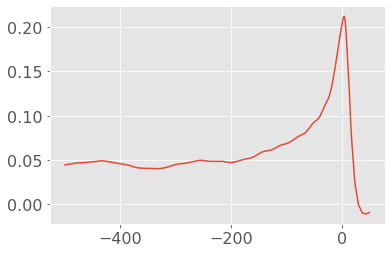

In [138]:
plt.figure()
plt.plot(times, ys[0])

In [151]:
def compare_models(index, ys_raw, preprocessing_params, coords, times_scaled, times, models):
    q = np.around(coords[0,index], 3)
    chi1 = np.around(coords[1,index], 3)
    theta1 = np.around(coords[2,index], 3)
    
    title = f"q = {q}, chi1 = {chi1}, theta1 = {theta1}"
    
    Xhat = compute_model_input(times_scaled, q, chi1, theta1)
    yhats = OrderedDict()
    for k, v in models.items():
        yhat = models[k].predict(Xhat).T
        
        yhats[k] = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
        
        
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(times, ys_raw[index], label='data')
    for k, v in yhats.items():
        plt.plot(times, v, label=k)
    plt.xlim(-200, 50)
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(2, 1, 2)
    for k, v in yhats.items():
#         plt.plot(times, 100*(ys_raw[index]-v)/ys_raw[index], label=f"% (data-{k})")
        plt.plot(times, (ys_raw[index]-v), label=f"(data-{k})")
#     plt.xlim(-200, 50)
#     plt.ylim(-10, 10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [152]:
np.where((coords[1] > 0.98) & (coords[2] > 1.3))

(array([ 73,  78, 754]),)

In [153]:
np.where((coords[1] > 0.6) & (coords[2] > 1.3) & (coords[2] < 1.6))

(array([ 25,  46,  63,  65,  98, 102, 104, 119, 123, 124, 175, 192, 193,
        194, 210, 222, 229, 233, 252, 266, 275, 304, 320, 360, 395, 411,
        422, 433, 449, 460, 476, 488, 493, 502, 538, 542, 545, 566, 568,
        570, 646, 659, 661, 684, 685, 745, 754, 767, 771, 788, 810, 836,
        840, 852, 891, 948, 970]),)

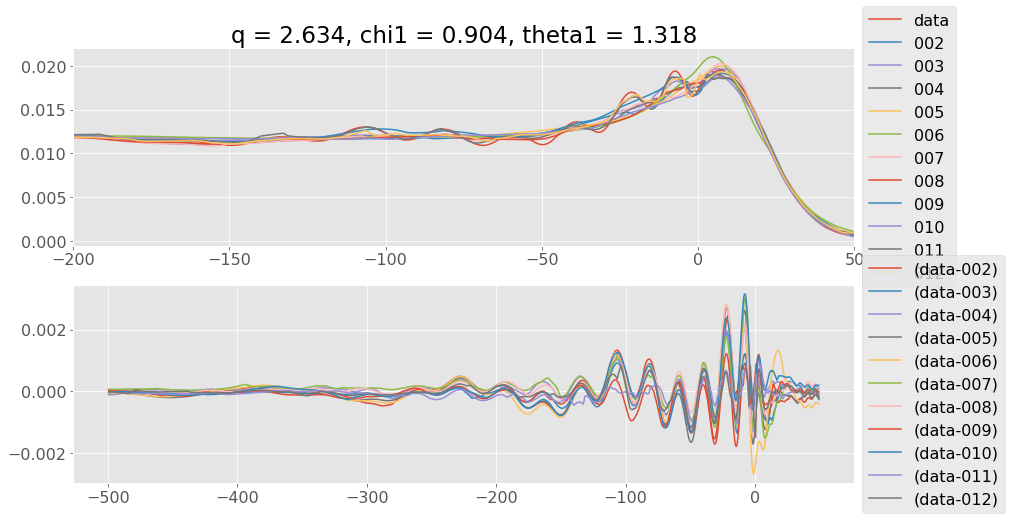

In [155]:
compare_models(index=25, ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

In [25]:
# Xhat = convert_input_for_ann(times_scaled, *coords[:, :10])
# # Xhat = convert_input_for_ann(times_scaled, *coords)
# # yhat = models['001'].predict(Xhat).T
# yhat = models['003'].predict(Xhat).T

In [27]:
# yhat.shape

In [143]:
def compute_errors(ys_raw, preprocessing_params, coords, times_scaled, times, models):
    
    n_cases = coords.shape[1]
#     max_loop = 10
    max_loop = n_cases
    
    yhats = OrderedDict()
    errors = OrderedDict()
    for k, v in models.items():
        
        if os.path.exists(f"errors_{k}.npy"):
            print("ALREADY CALCULATED LOADING DATA")
            errors[k] = np.load(f"errors_{k}.npy")
            continue
        
        print(f"working model: {k}")
        yhats[k] = np.zeros(shape=(n_cases, times_scaled.shape[0]))
        errors[k] = np.zeros(shape=(max_loop))

#         for index in tqdm(range(n_cases)):
        for index in tqdm(range(max_loop)):

            q = coords[0,index]
            chi1 = coords[1,index]
            theta1 = coords[2,index]

            Xhat = compute_model_input(times_scaled, q, chi1, theta1)
        
            yhat = models[k].predict(Xhat).T
            tt = compute_preprocessing.apply_pre_process_reverse(yhat, preprocessing_params['mean'], preprocessing_params['max'])[0]
            yhats[k][index] = tt
            
            errors[k][index] = np.max(100*(np.abs(ys_raw[index]-yhats[k][index]))/ys_raw[index])
            
        print("SAVING")
        np.save(f"errors_{k}.npy", errors[k])
        
    return errors

In [144]:
%%time
errors = compute_errors(ys_raw=ys_raw, preprocessing_params=ys_processing_params, coords=coords, times_scaled=times_scaled, times=times, models=models)

  0%|          | 1/1000 [00:00<02:16,  7.32it/s]

working model: 002


  0%|          | 0/1000 [00:00<?, ?it/s]

SAVING
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
ALREADY CALCULATED LOADING DATA
working model: 009


  0%|          | 0/1000 [00:00<?, ?it/s]

SAVING
working model: 010


  0%|          | 1/1000 [00:00<01:47,  9.33it/s]

SAVING
working model: 011


  0%|          | 1/1000 [00:00<01:53,  8.79it/s]

SAVING
working model: 012


100%|██████████| 1000/1000 [01:39<00:00, 10.08it/s]

SAVING
CPU times: user 11min 1s, sys: 1min 2s, total: 12min 3s
Wall time: 8min 30s


In [145]:
errors['003'].shape

(1000,)

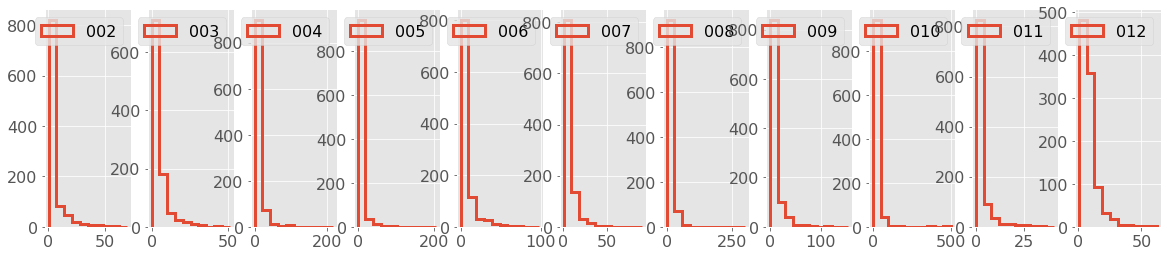

In [146]:
plt.figure(figsize=(20, 4))
for i,(k,v) in enumerate(errors.items()):
    plt.subplot(1, len(errors.keys()), i+1)
    plt.hist(np.abs(v), label=k, histtype='step', linewidth=3);
#     , density=True
    plt.legend()
# plt.xlim(0, 100)

In [147]:
max_idx = {}
for i,(k,v) in enumerate(errors.items()):
    max_value = np.max(np.abs(v))
    print(f"{k}: {max_value}")
    max_idx[k] = np.where(np.abs(v) == max_value)

002: 69.61574062258626
003: 51.09956439656638
004: 216.24130946469717
005: 204.34315062133416
006: 97.22520548826563
007: 89.15209315429532
008: 299.00635985070755
009: 152.9273412012914
010: 499.3587469467368
011: 40.444154988309954
012: 62.12942897976117


In [148]:
max_idx

{'002': (array([978]),),
 '003': (array([866]),),
 '004': (array([82]),),
 '005': (array([82]),),
 '006': (array([361]),),
 '007': (array([978]),),
 '008': (array([82]),),
 '009': (array([978]),),
 '010': (array([82]),),
 '011': (array([82]),),
 '012': (array([649]),)}

Text(0, 0.5, '$\\theta_1$')

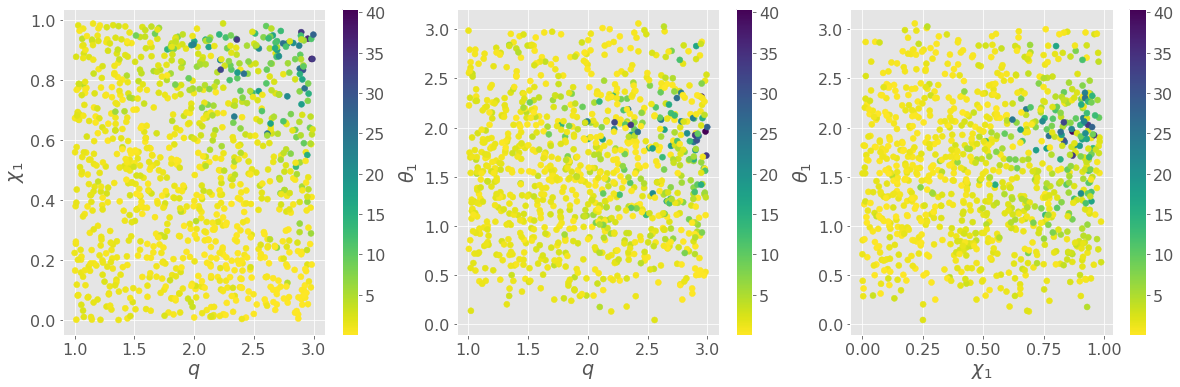

In [149]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.scatter(coords[0], coords[1], c=errors['011'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi_1$')
plt.subplot(1, 3, 2)
plt.scatter(coords[0], coords[2], c=errors['011'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\theta_1$')
plt.subplot(1, 3, 3)
plt.scatter(coords[1], coords[2], c=errors['011'], cmap='viridis_r')
plt.colorbar()
plt.xlabel(r'$\chi_1$')
plt.ylabel(r'$\theta_1$')